In [60]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt

bm.enable_x64()

In [61]:
class FitzHughNagumoModel(bp.DynamicalSystem):
  def __init__(self, method='exp_auto'):
    super(FitzHughNagumoModel, self).__init__()

    # parameters
    self.a = 0.7
    self.b = 0.8
    self.tau = 12.5

    # variables
    self.V = bm.Variable(bm.zeros(1))
    self.w = bm.Variable(bm.zeros(1))
    self.Iext = bm.Variable(bm.zeros(1))

    # functions
    def dV(V, t, w, Iext=0.): 
        return V - V * V * V / 3 - w + Iext
    def dw(w, t, V, a=0.7, b=0.8): 
        return (V + a - b * w) / self.tau
    self.int_V = bp.odeint(dV, method=method)
    self.int_w = bp.odeint(dw, method=method)

  def update(self, x=None):
    t, dt = bp.share.load('t', 'dt')
    self.V.value = self.int_V(self.V, t, self.w, self.Iext, dt)
    self.w.value = self.int_w(self.w, t, self.V, self.a, self.b, dt)
    self.Iext[:] = 0.

In [62]:
model = FitzHughNagumoModel()

In [63]:
pp = bp.analysis.PhasePlane2D(
  model,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  pars_update={'Iext': 0.8}, 
  resolutions={'V': 0.01, 'w': 0.01},
)

I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am creating the vector field ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 866 candidates
I am trying to filter out duplicate fixed points ...
	Found 1 fixed points.
	#1 V=-0.27292232485197654, w=0.5338542697623565 is a unstable node.
I am plotting the trajectory ...


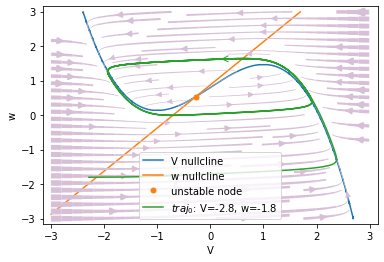

In [64]:
# By defaut, nullclines will be plotted as points, 
# while we can set the plot style as the line
pp.plot_nullcline(x_style={'fmt': '-'}, y_style={'fmt': '-'})

# Vector field can plotted as two ways:
# - plot_method="streamplot" (default)
# - plot_method="quiver"
pp.plot_vector_field()

# There are many ways to search fixed points. 
# By default, it will use the nullcline points of the first 
# variable ("V") as the initial points to perform fixed point searching
pp.plot_fixed_point()

# Trajectory plotting receives the setting of the initial points.
# There may be multiple trajectories, therefore the initial points 
# should be provived as a list/tuple/numpy.ndarray/Array
pp.plot_trajectory({'V': [-2.8], 'w': [-1.8]}, duration=100.)

# show the phase plane figure
pp.show_figure()

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 5000 candidates
I am trying to filter out duplicate fixed points ...
	Found 500 fixed points.


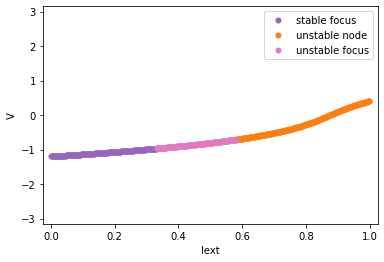

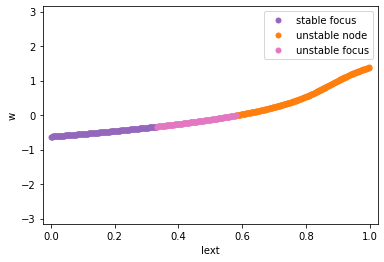

In [68]:
analyzer = bp.analysis.Bifurcation2D(
  model,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  target_pars={'Iext': [0., 1.]},
  resolutions={'Iext': 0.002},
)

# "num_rank" specifies the number of initial poinits for
# fixed point optimization under a set of parameters
analyzer.plot_bifurcation(num_rank=10)

# show figure
analyzer.show_figure()

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 50000 candidates
I am trying to filter out duplicate fixed points ...
	Found 4997 fixed points.


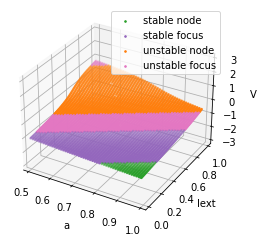

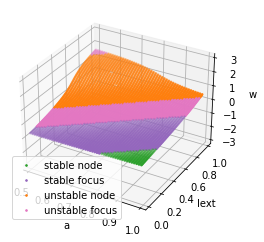

In [69]:
analyzer = bp.analysis.Bifurcation2D(
    model,
    target_vars=dict(V=[-3, 3], w=[-3., 3.]),
    target_pars=dict(a=[0.5, 1.], Iext=[0., 1.]),
    resolutions={'a': 0.01, 'Iext': 0.01},
)
analyzer.plot_bifurcation(num_rank=10, tol_aux=1e-9)
analyzer.show_figure()

# AdEx

In [65]:
def AdEx_patterns(group, Iext=65.):
    group.V[:], group.w[:] = group.V_reset, 0
    runner = bp.DSRunner(group, monitors=['V', 'w', 'spike'], inputs=('input', Iext))
    runner.run(500.)

    runner.mon.V = np.where(runner.mon.spike, 20., runner.mon.V)

    plt.plot(runner.mon.ts, runner.mon.V, label='V')
    plt.plot(runner.mon.ts, runner.mon.w, label='w')
    plt.legend()
    plt.xlabel(r'$t$ (ms)')

    plt.show()

In [66]:
def ppa_AdEx(group, v_range=None, w_range=None, Iext=65.):
    bm.enable_x64()
    if v_range is None:
        v_range = [-70., -40.]
    if w_range is None:
        w_range = [-10., 50.]
        
    phase_plane_analyzer = bp.analysis.PhasePlane2D(
        model=group,
        target_vars={'V': v_range, 'w': w_range, },  # 待分析变量
        pars_update={'I': Iext},  # 需要更新的变量
        resolutions=0.05
    )

    # 画出V, w的零增长曲线
    phase_plane_analyzer.plot_nullcline()
    # 画出奇点
    phase_plane_analyzer.plot_fixed_point()
    # 画出向量场
    phase_plane_analyzer.plot_vector_field()
    
    # 分段画出V, w的变化轨迹
    group.V[:], group.w[:] = group.V_reset, 0
    runner = bp.DSRunner(group, monitors=['V', 'w', 'spike'], inputs=('input', Iext))
    runner(500)
    spike = runner.mon.spike.squeeze()
    s_idx = np.where(spike)[0]  # 找到所有发放动作电位对应的index
    s_idx = np.concatenate(([0], s_idx, [len(spike) - 1]))  # 加上起始点和终止点的index
    for i in range(len(s_idx) - 1):
        vs = runner.mon.V[s_idx[i]: s_idx[i + 1]]
        ws = runner.mon.w[s_idx[i]: s_idx[i + 1]]
        plt.plot(vs, ws, color='darkslateblue')
        
    # 画出虚线 x = V_reset
    plt.plot([group.V_reset, group.V_reset], w_range, '--', color='grey', zorder=-1)
    
    plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

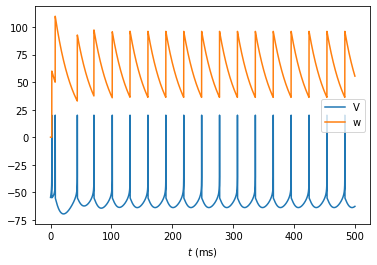

I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 368 candidates
I am trying to filter out duplicate fixed points ...
	Found 0 fixed points.
I am creating the vector field ...


  0%|          | 0/5000 [00:00<?, ?it/s]

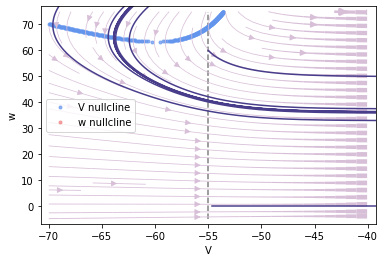

In [67]:
AdEx = bp.neurons.AdExIF

AdEx_patterns(AdEx(1, tau=20., a=0., tau_w=30., b=60., V_reset=-55.))
ppa_AdEx(AdEx(1, tau=20., a=0., tau_w=30., b=60., V_reset=-55.), w_range=[-5, 75.])

In [57]:
def ba_AdEx(group, v_range=None, w_range=None):
    bm.enable_x64()
    if v_range is None:
        v_range = [-70., -40.]
    if w_range is None:
        w_range = [-10., 50.]

    analyzer = bp.analysis.Bifurcation2D(
        group,
        target_vars=dict(V=v_range, w=w_range),
        target_pars=dict(I=[0., 70.]),
        resolutions={'I': 0.5},
    )
    analyzer.plot_bifurcation(num_rank=10, tol_aux=1e-9)
    analyzer.show_figure()

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 700 candidates
I am trying to filter out duplicate fixed points ...
	Found 3 fixed points.


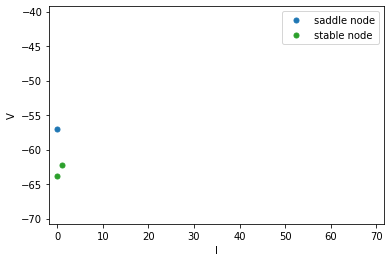

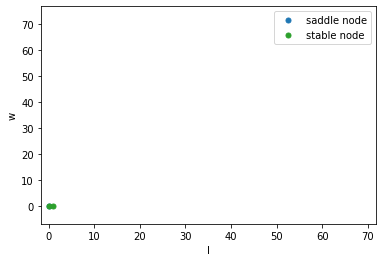

In [59]:
ba_AdEx(AdEx(1, tau=20., a=0., tau_w=30., b=60., V_reset=-55.), w_range=[-5, 75.])